In [13]:
! pip install geocoder
! pip install folium

     |████████████████████████████████| 102kB 9.4MB/s eta 0:00:01
     |████████████████████████████████| 102kB 8.3MB/s ta 0:00:011


In [14]:
#import relevant libraries
import pandas as pd # data analysis
import geocoder # convert address to lat and long
from geopy.geocoders import Nominatim 
import folium # map rendering
import requests # handle url requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
import pandas as pd

In [9]:
link = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
tables = pd.read_html(link)
df = pd.DataFrame(tables[0])
df.drop(['Location'], axis = 1, inplace = True)

In [11]:
df.head()

,Area,Latitude,Longitude
0,Amboli,19.129300,72.843400
1,"Chakala, Andheri",19.111388,72.860833
2,D.N. Nagar,19.124085,72.831373
3,Four Bungalows,19.124714,72.827210
4,Lokhandwala,19.130815,72.829270


In [15]:
address = 'Mumbai, India'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 19.0759899, 72.8773928.


In [17]:
# create map of Mumbai
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df['Latitude'], df['Longitude'], df['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)
    
map_mumbai

In [20]:
CLIENT_ID = '315JI21RCJPMNU5QHYDBU1SL3VRE5KFVYGKHE2YMTZQFPVLI' # your Foursquare ID
CLIENT_SECRET = 'YXJFLJVB5DER5KC2TRX1BIOWB1GMKBTOXMJ1LRSUISVNSHXZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [88]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],   
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
LIMIT = 100
mumbai_venues = getNearbyVenues(names=df['Area'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

In [90]:
mumbai_venues.head()

,Area,Latitude,Longitude,Venue,Venue Category
0,Amboli,19.1293,72.8434,Merwans Cake shop,Bakery
1,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,American Restaurant
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant
4,Amboli,19.1293,72.8434,Joey's Pizza,Pizza Place


In [91]:
len(mumbai_venues['Venue Category'].unique())

173

In [169]:
mumbai_venues.groupby('Venue Category').count().sort_values(['Area'], ascending = False, axis = 0).head(10)

,Area,Latitude,Longitude,Venue
Venue Category,,,,
Indian Restaurant,1077,1077,1077,1077
Ice Cream Shop,395,395,395,395
Café,357,357,357,357
Coffee Shop,310,310,310,310
Hotel,300,300,300,300
Dessert Shop,266,266,266,266
Restaurant,264,264,264,264
Fast Food Restaurant,258,258,258,258
Chinese Restaurant,220,220,220,220


In [172]:
mumbai_venues=mumbai_venues[mumbai_venues['Venue Category']!='Indian Restaurant']

In [194]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
mumbai_onehot['Area'] = mumbai_venues['Area'] 

# move neighbourhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_grouped = mumbai_onehot.groupby('Area').mean()


In [195]:
mumbai_grouped.reset_index(inplace=True)

In [196]:
mumbai_grouped.head(1)

,Area,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,Aarey Milk Colony,0.0,0.0,0.0,0.0,0.0,0.036145,0.0,0.0,0.012048,...,0.0,0.0,0.0,0.0,0.0,0.024096,0.0,0.0,0.0,0.0


In [197]:
kclusters = 9

mumbai_grouped_clustering = mumbai_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering) 

# add clustering labels
mumbai_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(mumbai_grouped.set_index('Area'), on='Area')

mumbai_merged.head() # check the last columns!

,Area,Latitude,Longitude,Cluster Labels,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,Amboli,19.129300,72.843400,4.0,0.0,0.000000,0.022727,0.0,0.0,0.000000,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0
1,"Chakala, Andheri",19.111388,72.860833,7.0,0.0,0.011364,0.022727,0.0,0.0,0.022727,...,0.011364,0.0,0.011364,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,D.N. Nagar,19.124085,72.831373,4.0,0.0,0.000000,0.022727,0.0,0.0,0.000000,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0
3,Four Bungalows,19.124714,72.827210,4.0,0.0,0.000000,0.022472,0.0,0.0,0.000000,...,0.011236,0.0,0.000000,0.011236,0.0,0.0,0.0,0.0,0.0,0.0
4,Lokhandwala,19.130815,72.829270,4.0,0.0,0.000000,0.022727,0.0,0.0,0.000000,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
mumbai_merged.dropna(inplace=True)

In [199]:
mumbai_merged['Cluster Labels'] = mumbai_merged['Cluster Labels'].astype(int)

In [200]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Area'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [201]:
mumbai_plot=mumbai_merged.groupby('Cluster Labels').mean()

In [202]:
mumbai_plot.drop(['Latitude'],axis=1,inplace=True)
mumbai_plot.drop(['Longitude'],axis=1,inplace=True)

In [203]:
mumbai_plot.reset_index(inplace=True)

In [204]:
mumbai_plot

,Cluster Labels,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,0,0.000000,0.000000,0.000000,0.005170,0.000000,0.003265,0.000000,0.000000,0.009372,...,0.003265,0.010622,0.000000,0.000000,0.030779,0.012662,0.004907,0.000000,0.000000,0.002695
1,1,0.000000,0.000000,0.000376,0.000000,0.006018,0.011524,0.004532,0.000000,0.000328,...,0.007619,0.000000,0.006459,0.000000,0.000376,0.011311,0.000000,0.000000,0.000376,0.002437
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.001203,0.012396,0.005963,0.000000,0.003084,0.001268,0.007012,0.004752,...,0.008223,0.000000,0.000000,0.003549,0.000000,0.003721,0.000000,0.000000,0.000000,0.002545
5,5,0.002990,0.000000,0.008335,0.003752,0.000000,0.013578,0.002934,0.000000,0.004140,...,0.002917,0.007111,0.001506,0.001337,0.003818,0.022811,0.004840,0.002216,0.000000,0.000679
6,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000
7,7,0.008294,0.010580,0.011716,0.000000,0.000000,0.020038,0.000000,0.000000,0.010635,...,0.002286,0.008294,0.010580,0.000000,0.000000,0.017724,0.000000,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [205]:
mumbai_plot=mumbai_plot.drop(['Cluster Labels'],axis=1).T.reset_index()

In [206]:
mumbai_plot.head(2)

,index,0,1,2,3,4,5,6,7,8
0,Afghan Restaurant,0.0,0.0,0.0,0.0,0.000000,0.00299,0.0,0.008294,0.0
1,Airport Service,0.0,0.0,0.0,0.0,0.001203,0.00000,0.0,0.010580,0.0


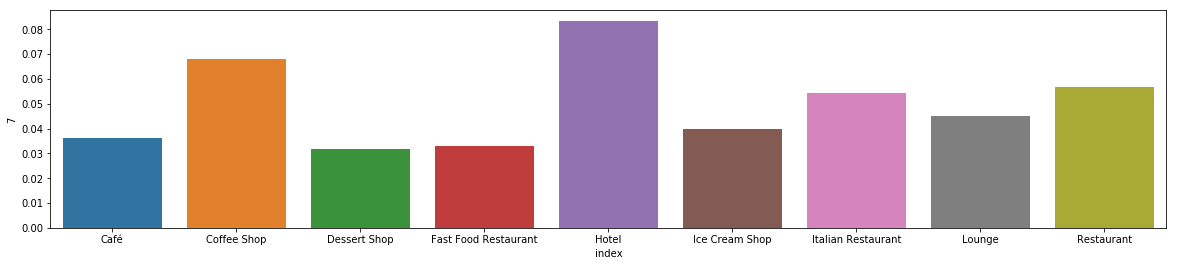

In [211]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=7,data=mumbai_plot[mumbai_plot[7]>0.03], ax=ax)

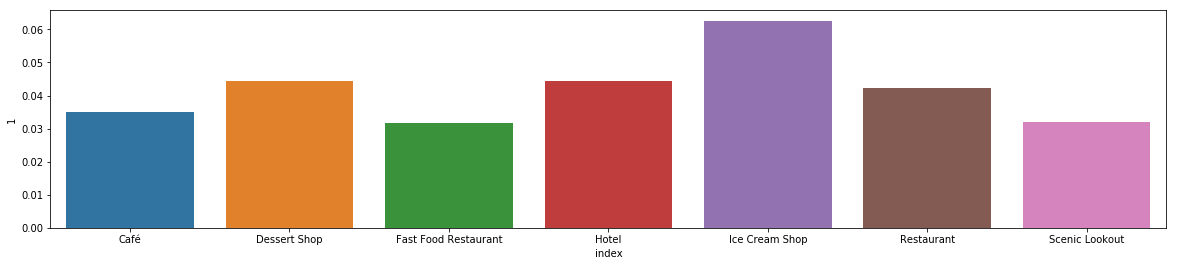

In [210]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=1,data=mumbai_plot[mumbai_plot[1]>0.03], ax=ax)

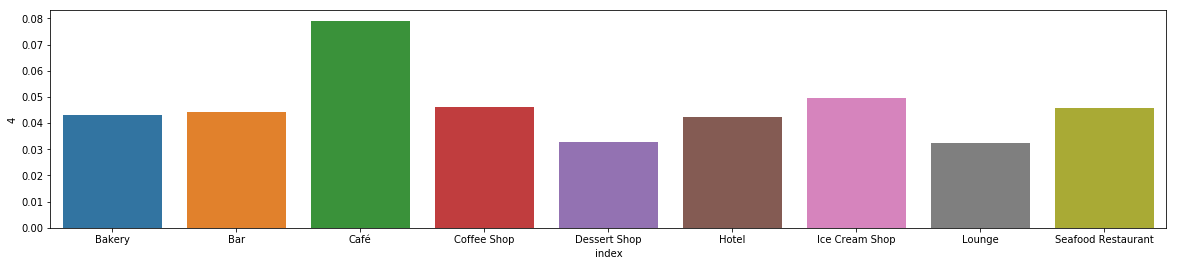

In [212]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=4,data=mumbai_plot[mumbai_plot[4]>0.03], ax=ax)

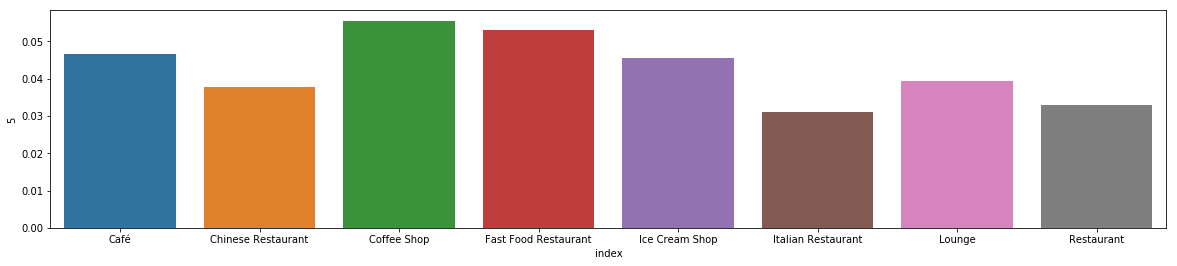

In [213]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=5,data=mumbai_plot[mumbai_plot[5]>0.03], ax=ax)

In [214]:
mumbai_venues.head()

,Area,Latitude,Longitude,Venue,Venue Category
0,Amboli,19.1293,72.8434,Merwans Cake shop,Bakery
1,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,American Restaurant
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant
4,Amboli,19.1293,72.8434,Joey's Pizza,Pizza Place


In [232]:
mumbai_venues.groupby('Venue').count().sort_values(['Area'], ascending = False, axis = 0).head(15)

,Area,Latitude,Longitude,Venue Category
Venue,,,,
Starbucks,177,177,177,177
Theobroma,79,79,79,79
Cafe Coffee Day,53,53,53,53
Doolally Taproom,41,41,41,41
Domino's Pizza,40,40,40,40
Mad Over Donuts,39,39,39,39
Subway,36,36,36,36
Mainland China,36,36,36,36
Trident,35,35,35,35


In [216]:
mumbai_sb=mumbai_venues[mumbai_venues['Venue']=='Starbucks']

In [223]:
mumbai_sb=mumbai_sb.groupby('Area').mean().reset_index()

In [225]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_sb['Latitude'], mumbai_sb['Longitude'], mumbai_sb['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [226]:
mumbai_ccd=mumbai_venues[mumbai_venues['Venue']=='Cafe Coffee Day']
mumbai_ccd=mumbai_ccd.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_ccd['Latitude'], mumbai_ccd['Longitude'], mumbai_ccd['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [230]:
mumbai_dp=mumbai_venues[mumbai_venues['Venue']=='Domino\'s Pizza']
mumbai_dp=mumbai_dp.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_dp['Latitude'], mumbai_dp['Longitude'], mumbai_dp['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [231]:
mumbai_sw=mumbai_venues[mumbai_venues['Venue']=='Subway']
mumbai_sw=mumbai_sw.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_sw['Latitude'], mumbai_sw['Longitude'], mumbai_sw['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters